In [4]:
# import sys
# sys.path.append('../Scripts')
# from PostProcessingScripts import * 
# import pandas as pd 
# import string 
# just to make the cells appear wider:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import string


In [2]:
class COMPASData(object):
    """ this class reads in datafile & gives you M1 and M2 and some other things """

    def __init__(self, path=None, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1):
        self.path                = path
        if (self.path is None):
            print("Just to double check you create instance of ClassCOMPAS without path/Data")
        elif not  os.path.isfile(path):
            raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%path)
        elif os.path.isfile(path):
            self.h5file           = h5.File(path)
        # old code with fixed COMPAS h5 filename:
        #
        # elif not  os.path.isfile(path+'COMPASOutput.h5'):
        #     raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%path)
        # elif os.path.isfile(path+'COMPASOutput.h5'):
        #     self.h5file           = h5.File(path+'COMPASOutput.h5')



        #Crucial values to be able to calculate MSSFR
        self.metallicityGrid     = None
        self.metallicitySystems  = None
        self.delayTimes          = None
        #Crucial values I need for selection effects
        self.mass1               = None
        self.mass2               = None

        self.m1zams               = None
        self.m2zams               = None
        self.separationzams       = None

        self.weight              = None  # //floor
        self.DCOmask             = None

        #Additional arrays that might be nice to store
        #to more quickly make some plots.
        #If you need more memory might help a tiny bit to not do
        self.lazyData            = lazyData
        self.pessimictic_allDCO  = None  #which of all DCO are pessimistic
        self.pessimictic_subSet  = None  #which of the systems calculated are pessimistic
        self.mChirp              = None
        self.q                   = None
        self.eccentricityDCOFormation = None
        self.separationDCOFormation =None
        self.tc                  = None
        self.seeds               = None
        self.systemicVelocity    = None

        self.Mlower              = Mlower
        self.Mupper              = Mupper
        self.binaryFraction      = binaryFraction
        self.totalMassEvolvedPerZ = None
        
#         if self.path is not None:
#            self.setGridAndMassEvolved()        

#         print("Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()")

    
    def setCOMPASDCOmask(self, types='BBH', withinHubbleTime=True, optimistic=False):
            #We do not want all the formation channels just the ones that form BBHs
            fDCO    = self.h5file['doubleCompactObjects']
            if types == 'BBH':
                maskTypes = (fDCO['stellarType1'][...].squeeze() == 14) &\
                            (fDCO['stellarType2'][...].squeeze() == 14)
            elif types == 'BNS':
                maskTypes = (fDCO['stellarType1'][...].squeeze() == 13) &\
                            (fDCO['stellarType2'][...].squeeze() == 13)
            elif types == 'BHNS':
                maskTypes = ((fDCO['stellarType1'][...].squeeze() == 14) &\
                            (fDCO['stellarType2'][...].squeeze() == 13)) |\
                            ((fDCO['stellarType1'][...].squeeze() == 13) &\
                            (fDCO['stellarType2'][...].squeeze() == 14))
            elif types == 'ALL':
                maskTypes = ((fDCO['stellarType1'][...].squeeze() == 14) |\
                            (fDCO['stellarType1'][...].squeeze() == 13)) &\
                            ((fDCO['stellarType2'][...].squeeze() == 13) |\
                            (fDCO['stellarType2'][...].squeeze() == 14))
            else:
                raise ValueError('types=%s not in BBH, BNS, BHNS' %(types))         
            if withinHubbleTime == True:
                maskHubble = (fDCO['mergesInHubbleTimeFlag'][...].squeeze()==True)
            else:
                #Array where all are true
                maskHubble = np.ones(len(fDCO['mergesInHubbleTimeFlag'][...].squeeze()), dtype=bool)
                              
            if optimistic == True:
                #we do not care about the optimistic flag (both False and True allowed)
                #Array where all are true
                maskOptimistic = np.ones(len(fDCO['optimisticCEFlag'][...].squeeze()), dtype=bool)
            else:
                #optimistic scenario not allowed (pessimistic) hence the flag must be false
                #This removes systems with CEE from HG donors (no core envelope separation)
                maskOptimistic = fDCO['optimisticCEFlag'][...].squeeze() == False
                              
            #we never want in first timestep after CEE, because 
            #we define it as a system that should not have survived the CEE
            maskNoRLOFafterCEE =  (fDCO['RLOFSecondaryAfterCEE'][...].squeeze()==False)
                              

            self.DCOmask = maskTypes & maskHubble & maskOptimistic & maskNoRLOFafterCEE

#     def setGridAndMassEvolved(self):
    
#         #The COMPAS simulation does not evolve all stars 
#         #give me the correction factor for the total mass evolved
#         #I assume each metallicity has the same limits, and does correction
#         #factor, but the total mass evolved might be different.
#         #This does not change when we change types and other masks this is 
#         #general to the entire simulation so calculate once
#         _, self.totalMassEvolvedPerZ =\
#         MPZ.totalMassEvolvedPerZ(pathCOMPASh5=self.path , Mlower=self.Mlower, \
#                                  Mupper=self.Mupper, binaryFraction=self.binaryFraction)
#         #Want to recover entire metallicity grid, assume that every metallicity
#         #evolved shows in all systems again should not change within same run
#         #so dont redo if we reset the data
#         metallicities = self.h5file['systems']['Metallicity1'][...].squeeze()
#         self.metallicityGrid     = np.unique(metallicities)


    def setCOMPASData(self):
        fDCO      = self.h5file['doubleCompactObjects']
        #Stuff I need for cosmological integral
        

        #sorry not the prettiest line is a boolean slice of seeds
        #this only works because seeds in systems file and DCO file are printed
        #in same order

        #TODO more elegant slicing not unpack all and then mask 
        #something like f[M1][mask][...] but the the way I setup DCO mask needs different shape
        #metallicities = metallicities[np.in1d(self.h5file['systems']['SEED'][...].squeeze(),\
        #                        fDCO['seed'][...].squeeze()[self.DCOmask])]
        
        self.metallicitySystems  = fDCO['Metallicity1'][...].squeeze()[self.DCOmask]
        self.delayTimes          = fDCO['tform'][...].squeeze()[self.DCOmask] + \
                                   fDCO['tc'][...].squeeze()[self.DCOmask]
        self.tc                  = fDCO['tc'][...].squeeze()[self.DCOmask]
        self.mass1               = fDCO['M1'][...].squeeze()[self.DCOmask]
        self.mass2               = fDCO['M2'][...].squeeze()[self.DCOmask]
        self.weight              = fDCO['weight'][...].squeeze()[self.DCOmask] # //floor
        self.m1zams              = fDCO['M1ZAMS'][...].squeeze()[self.DCOmask]
        self.m2zams              = fDCO['M2ZAMS'][...].squeeze()[self.DCOmask]
        self.separationzams      = fDCO['separationInitial'][...].squeeze()[self.DCOmask]


        

        

        #Stuff of data I dont need for integral
        #but I might be to laze to read in myself
        #and often use. Might turn it of for memory efficiency
        if self.lazyData:
            self.pessimictic_allDCO  = fDCO['optimisticCEFlag'][...].squeeze()==False
            self.pessimictic_subSet  = fDCO['optimisticCEFlag'][...].squeeze()[self.DCOmask]==False
            self.q                   = np.divide(self.mass2, self.mass1)
            boolq                    = self.mass2 > self.mass1
            self.q[boolq]            = np.divide(self.mass1[boolq], self.mass2[boolq])
            self.mChirp = np.divide((np.multiply(self.mass2, self.mass1)**(3./5.) ),\
                                           (np.add(self.mass2, self.mass1)**(1./5.)))

            self.separationDCOFormation= fDCO['separationDCOFormation'][...].squeeze()[self.DCOmask]
            self.eccentricityDCOFormation= fDCO['eccentricityDCOFormation'][...].squeeze()[self.DCOmask]
            self.seeds               = fDCO['seed'][...].squeeze()[self.DCOmask]
            self.Hubble              = fDCO['mergesInHubbleTimeFlag'][...].squeeze()[self.DCOmask]

            fSN     = self.h5file['supernovae']
            seedsSN = fSN ['randomSeed'][...].squeeze()
            bools = np.in1d(seedsSN, self.seeds)
            self.systemicVelocity    = fSN['systemicVelocity'][...].squeeze()[bools]


#     def setGridAndMassEvolved(self):

#         #The COMPAS simulation does not evolve all stars 
#         #give me the correction factor for the total mass evolved
#         #I assume each metallicity has the same limits, and does correction
#         #factor, but the total mass evolved might be different.
#         #This does not change when we change types and other masks this is 
#         #general to the entire simulation so calculate once
#         _, self.totalMassEvolvedPerZ =\
#         MPZ.totalMassEvolvedPerZ(pathCOMPASh5=self.path , Mlower=self.Mlower, \
#                                  Mupper=self.Mupper, binaryFraction=self.binaryFraction)
#         #Want to recover entire metallicity grid, assume that every metallicity
#         #evolved shows in all systems again should not change within same run
#         #so dont redo if we reset the data
#         metallicities = self.h5file['systems']['Metallicity1'][...].squeeze()
#         self.metallicityGrid     = np.unique(metallicities)


In [4]:



!ls

! pwd

BHBH_COMPAS_model_A.pdf
BHBH_COMPAS_model_A.png
BHNS_COMPAS_model_A.png
ClassCOMPAS.py
FastCosmicIntegration.py
Load Efficiently COMPAS pulsar data .ipynb
README_DCOs.txt
SNR_Grid_IMRPhenomPv2_FD_all_noise.hdf5
Untitled.ipynb
__pycache__
demo_black_hole_spins_for_pop_synth.ipynb
demo_calculate_formation_efficiency_per_solar_mass_evolved.ipynb
demo_caution_with_log_tdelay.ipynb
demo_plotting_BHNS_distributions_for_LVK.ipynb
demo_plotting_BHNS_distributions_for_astrophysical_and_LVK-population.ipynb
ppdo.eps
reading_in_basic_parameters_hdf5_datafile-Copy1.ipynb
reading_in_basic_parameters_hdf5_datafile-Copy2.ipynb
reading_in_basic_parameters_hdf5_datafile.ipynb
selection_effects.py
totalMassEvolvedPerZ.py
/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/demo_read_hdf5_file


# 3 "The Big file" with all the data points: Note that my data is weighted!

all lines of code that you might have to change are given with "# change this line! " 

In [11]:

path = '/Users/floorbroekgaarden/Projects/GitHub/COMPAS/stroopwafel_test/run_4/batch_0/batch_0.h5' # change this line! 



fdata = h5.File(path)
print(fdata.keys())

SP = fdata['BSE_System_Parameters']

# print(SP.keys())

metallicityM2 = SP['Metallicity@ZAMS(2)'][()]
# print(metallicityM2)


for keys in fdata.keys():
    print(keys)
    SEED =  fdata[keys]['SEED'][()]
    print(SEED)
    print('\n')



<KeysViewHDF5 ['BSE_Common_Envelopes', 'BSE_Double_Compact_Objects', 'BSE_RLOF', 'BSE_Supernovae', 'BSE_System_Parameters', 'Run_Details']>
BSE_Common_Envelopes
[  0   1   2   3   7  10  13  15  18  19  22  24  26  27  28  33  35  36
  37  38  40  42  43  45  46  48  49  51  52  54  62  63  64  65  69  71
  72  73  75  77  79  82  83  84  86  87  89  92  95  97  99 100 103 104
 105 107 108 109 110 112 116 117 119 120 121 123 125 129 130 131 136 138
 140 141 146 147 151 153 155 156 158 160 162 163 165 166 167 168 171 173
 174 175 176 177 179 181 182 183 184 187 189 191 192 193 194 198 199 202
 205 207 208 210 211 213 214 215 217 218 219 220 221 222 224 225 227 228
 229 230 233 235 237 239 241 242 245]


BSE_Double_Compact_Objects
[  6  11  50  61  83  98 104 115 118 122 135 144 166 171 212 216 223 226
 236 240 244]


BSE_RLOF
[  0   1   2 ... 244 244 245]


BSE_Supernovae
[  4   5   6   6   8   8   9  11  11  12  13  14  16  17  20  20  21  23
  24  25  29  30  31  32  33  34  39  39  4

KeyError: "Unable to open object (object 'SEED' doesn't exist)"

In [4]:
# to obtain properties of ALL binaries simulated, do this:

DCOtype = 'BHNS'   # You can change this line to 'BBH', 'BHNS' 'BNS', or 'ALL' (All DCOs)  # change this line! 




# add path to where the COMPASOutput.h5 file is stored. 
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different
path = '~/Downloads/COMPASCompactOutput_'+ DCOtype +'_K.h5' # change this line! 



fdata = h5.File(path)
# shows the different files within the hdf5 folder 
print(fdata.keys())



print('this might take a little while, particularly if you are using the BBH')

# This code below gets the COMPAS data and only the systems that are DCOs 
Data            = COMPASData(path=path, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1)
Data.setCOMPASDCOmask(types=DCOtype,  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
# SeedsHubble    = Data.seeds[Data.Hubble==True]



M1 = Data.mass1
M2 = Data.mass2
weights = Data.weight

print(M1)
print(M2)










OSError: Unable to create file (unable to open file: name = '~/Downloads/COMPASCompactOutput_BHNS_K.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = a02)

### M1, M2 and Chirpmass in Msun

not that these parameters are the properties for the selected DCOtype 

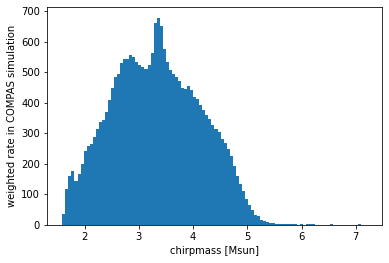

this distribution is not yet SFRD(Z,z) and detector weighted


In [22]:
# to obtain the properties of the selected DCOtype you simply do this:
M1 = Data.mass1
M2 = Data.mass2
weights = Data.weight


def chirpmass(m1, m2):
    numer = (m1*m2)**(3./5)
    denom = (m1+m2)**(1./5)
    
    return numer/denom

# and you can plot properties, e.g., the chirpmass distribution: 
chirpmass =chirpmass(m1=M1, m2=M2)


plt.hist(chirpmass, bins=100, weights=weights)
plt.xlabel('chirpmass [Msun]')
plt.ylabel('weighted rate in COMPAS simulation')
plt.show()

print('this distribution is not yet SFRD(Z,z) and detector weighted')


### M1 more massive, M2 least massive:






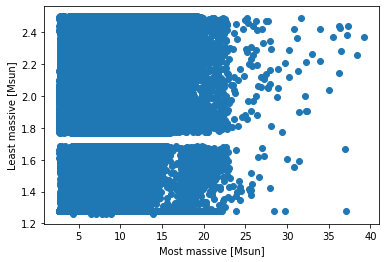

In [23]:
def obtainM1BHandM2BHassymetric(m1, m2):
    m1bh, m2bh = np.zeros_like(m1), np.zeros_like(m1)
    maskm1heavier = ( m1 >= m2)
    maskm2heavier = (m1 < m2)
    
    m1bh[maskm1heavier] = m1[maskm1heavier] 
    m1bh[maskm2heavier] = m2[maskm2heavier]
    m2bh[maskm1heavier] = m2[maskm1heavier]
    m2bh[maskm2heavier] = m1[maskm2heavier]
    
    return m1bh, m2bh # m1bh has all the heaviest systems



M_most_massive, M_least_massive = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)


plt.scatter(M_most_massive, M_least_massive)
plt.xlabel('Most massive [Msun]')
plt.ylabel('Least massive [Msun]')
plt.show()



### Metallicity 

the metallicity of each data point can be obtained with "metallicitySystems"
I used a total of 53 different metallicity bins, quoted in the bottem when printing "Data.metallicityGrid" 

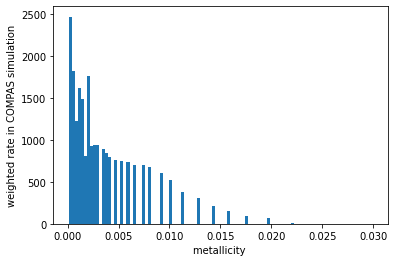

[0.0001  0.00011 0.00012 0.00014 0.00016 0.00017 0.00019 0.00022 0.00024
 0.00027 0.0003  0.00034 0.00037 0.00042 0.00047 0.00052 0.00058 0.00065
 0.00073 0.00081 0.0009  0.00101 0.00113 0.00126 0.0014  0.00157 0.00175
 0.00195 0.00218 0.00243 0.00272 0.00303 0.00339 0.00378 0.00422 0.00471
 0.00526 0.00587 0.00655 0.00732 0.00817 0.00912 0.01018 0.01137 0.01269
 0.01416 0.01581 0.01765 0.01971 0.022   0.0244  0.02705 0.03   ]
53


In [24]:
metallicitySystems = Data.metallicitySystems
plt.hist(metallicitySystems, bins=100, weights=weights)
plt.xlabel('metallicity ')
plt.ylabel('weighted rate in COMPAS simulation')
plt.show()


Data.metallicityGrid = np.unique(metallicitySystems)
print(Data.metallicityGrid)
print(len(Data.metallicityGrid))




### Delay time  of each simulated data point in Myr

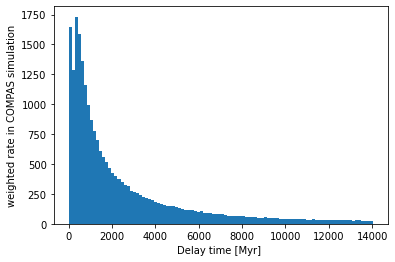

In [8]:
delayTimes = Data.delayTimes


plt.hist(delayTimes, bins=100, weights=weights)
plt.xlabel('Delay time [Myr] ')
plt.ylabel('weighted rate in COMPAS simulation')
plt.show()




# 1. formation efficiency file: 


For each model A, B, C, ... Q,  I made an formation efficiency file with the parameters structured as you suggested: 
Below is an example for how to read in this data for model "A" (which corresponds to the big DATA file I gave you

In [9]:
bps_name = 'A'
pathCSVfile = '/Users/floorbroekgaarden/Projects/GitHub/Double-Compact-Object-Mergers/dataFiles/Martyna_SFRD/1_formation_efficiency/formation_efficiency_' +bps_name+ '' +  '.csv'

df = pd.read_csv(pathCSVfile, index_col=0)

        
print(df)


         Zi     X(Zi)_DNS    X(Zi)_BHBH    X(Zi)_BHNS
0   0.00010  5.965332e-07  4.520192e-05  1.570943e-06
1   0.00011  4.758306e-07  4.633445e-05  2.007287e-06
2   0.00012  5.569142e-07  4.696560e-05  2.134851e-06
3   0.00014  5.448654e-07  4.734547e-05  2.145098e-06
4   0.00016  7.719925e-07  4.755733e-05  2.174396e-06
5   0.00017  6.265832e-07  4.750986e-05  2.225978e-06
6   0.00019  7.544551e-07  4.851627e-05  2.144975e-06
7   0.00022  1.044446e-06  4.788043e-05  2.371202e-06
8   0.00024  1.489758e-06  4.876057e-05  2.261335e-06
9   0.00027  1.921628e-06  4.911843e-05  2.695409e-06
10  0.00030  2.294481e-06  4.955859e-05  2.912616e-06
11  0.00034  2.455971e-06  5.037767e-05  3.284954e-06
12  0.00037  2.847475e-06  5.038026e-05  3.435441e-06
13  0.00042  2.888395e-06  5.103750e-05  4.016671e-06
14  0.00047  2.947169e-06  5.077655e-05  4.422328e-06
15  0.00052  2.961805e-06  5.027988e-05  4.732527e-06
16  0.00058  3.017476e-06  4.977026e-05  4.934465e-06
17  0.00065  3.082642e-06  4

you can easily plot the formation rates for this model: 
    
    
    

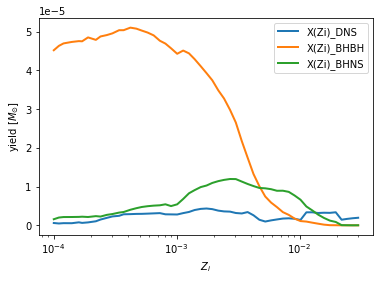

In [10]:

for ind_DCO, name_DCO in enumerate(['X(Zi)_DNS',    'X(Zi)_BHBH',    'X(Zi)_BHNS']):    

    plt.plot(df['Zi'], df[name_DCO], label=name_DCO, lw=2) 

plt.xscale('log')
plt.xlabel(r'$Z_i$')
plt.ylabel(r'yield $[M_{\odot}]$')
plt.legend()    
plt.show()
    
    
    

# 2. delay time distribution; 

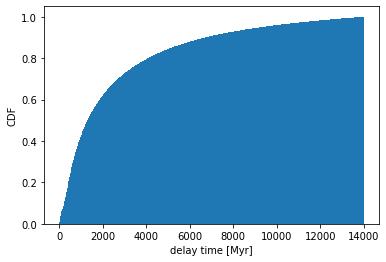

In [11]:
bins = np.linspace(0, 14000, 1000) # Myr 


plt.hist(Data.delayTimes, bins=bins, weights=Data.weight, cumulative=True, density=True)

plt.ylabel('CDF')
plt.xlabel('delay time [Myr]')
plt.show()





In [ ]:
# to obtain properties of ALL binaries simulated, do this:

DCOtype = 'BNS'   # You can change this line to 'BBH', 'BHNS' 'BNS', or 'ALL' (All DCOs)  # change this line! 




# add path to where the COMPASOutput.h5 file is stored. 
# For you the part '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/' is probably different
path = '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 



fdata = h5.File(path)
# shows the different files within the hdf5 folder 
print(fdata.keys())



print('this might take a little while, particularly if you are using the BBH')

# This code below gets the COMPAS data and only the systems that are DCOs 
Data            = COMPASData(path=path, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1)
Data.setCOMPASDCOmask(types=DCOtype,  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
# SeedsHubble    = Data.seeds[Data.Hubble==True]










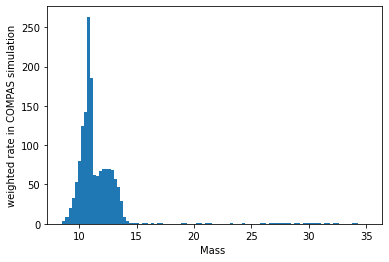

[0.0001  0.00011 0.00012 0.00014 0.00016 0.00017 0.00019 0.00022 0.00024
 0.00027 0.0003  0.00034 0.00037 0.00042 0.00047 0.00052 0.00058 0.00065
 0.00073 0.00081 0.0009  0.00101 0.00113 0.00126 0.0014  0.00157 0.00175
 0.00195 0.00218 0.00243 0.00272 0.00303 0.00339 0.00378 0.00422 0.00471
 0.00526 0.00587 0.00655 0.00732 0.00817 0.00912 0.01018 0.01137 0.01269
 0.01416 0.01581 0.01765 0.01971 0.022   0.0244  0.02705 0.03   ]
53


In [18]:

metallicitySystems = Data.metallicitySystems


M1ZAMS = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
M2ZAMS = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()


mask = metallicitySystems > 0.014

plt.hist(M1ZAMS[mask], bins=100, weights=weights[mask])
plt.xlabel('Mass ')
plt.ylabel('weighted rate in COMPAS simulation')
plt.show()


Data.metallicityGrid = np.unique(metallicitySystems)
print(Data.metallicityGrid)
print(len(Data.metallicityGrid))




In [29]:
aa = np.logspace(np.log10(0.0141), np.log10(0.01975), 8)
print(np.round(aa,4))

[0.0141 0.0148 0.0155 0.0163 0.0171 0.0179 0.0188 0.0198]
